# Problem 2

## Problem 2(a)
Using python-fsps, generate integrated magnitudes in V and I (Vega Magnitudes) for a simple stellar population that has parameters similar to the best fitting parameters you found for M92 in Problem (1). Specify which stellar evolution model and stellar atmosphere model you use.

Here, for the stellar atmosphere models fsps uses MILES. For the stellar evolution models fsps uses MIST.

In [2]:
import fsps
import numpy as np
from scipy.stats import norm
import emcee
import corner
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
text_size = 16

Here, I chose the Kroupa IMF (I used the Kroupa IMF in the PARSEC models and it is the IMF used by MIST). I set zmet = 2, because that corresponded to a metallicity of $log(Z/Z_{\odot})$ = -2.00 which is the closest to the value reported in Wikipedia for the MIST models. For metallicity, I allow the range to be -1.75 to -2.5.

1. Age: 14.2 Gyr (wikipedia)
2. Metallicity: -2.00 (closest value to -2.16, from wikipedia)
3. Distance = 8200 pc (wikipedia)
4. Av = 0.034 (from NED)

In [129]:
sp = fsps.StellarPopulation(compute_vega_mags=True, imf_type = 2, zmet=2, dust_type=1)

In [130]:
#generate data
extinction = 0.034 # from NED
def make_data(filters, sigma):
    mags = sp.get_mags(tage=14.2, bands=filters)
    errors = np.random.normal(loc = 0., scale = sigma, size = np.size(mags))
    mags = mags + 5.*np.log10(8.2e3) - 5. + errors + extinction
    return mags

## Problem 2(b)
Assuming normally distributed 1-$\sigma$ uncertainties of 0.1 mag in both bands, add random Gaussian noise to your mock photometry. Then use python-fsps and emcee to fit for the age, metallicity, distance and extinction of your mock M92-like cluster. Justify any priors you adopt (e.g., you may end up exploring a strong prior on distance). Show the resulting triangle plots and discuss how well constrained (or not) the parameters are.

In [131]:
# theta = (z, age, dist, av)
z_min = -2.75
z_max = -1.625
age_min = 10.
age_max = 14.5
dist_min = 7.
dist_max = 9.
av_min = 0.001
av_max = 0.1

def lnprior(theta):
    """This Prior function sets hard limits on the age, metallicity, distance and extinction."""
    if (z_max>theta[0]>z_min) and (age_min < theta[1] < age_max) and (dist_min<theta[2]<dist_max)\
    and (av_max > theta[3] > av_min):
        return 0.0
    return -np.inf

In [132]:
def ln_like(theta, mags, sigma, filters):
    """For the likelihood function I use a function from scipy that finds the log probability 
    that the data magnitudes were drawn from a gaussian dist. centered at the test magnitudes."""
    #find out the appropriate zmet value from the value of Fe/H
    if -2.75<theta[0]<-2.25:
        z = 1
    elif -2.25<theta[0]<-1.875:
        z = 2
    elif -1.875<theta[0]<-1.625:
        z = 3
    else:
        return -np.inf
    mags_test = sp.get_mags(tage = theta[1], zmet = z, bands = filters)
    mags_test = mags_test + 5*np.log10(theta[2]*(1e3)) - 5 + theta[3]
    prob = norm.logpdf(mags, loc = mags_test, scale = sigma)
    return np.sum(prob)

In [133]:
def lnprob(theta, mags, sigma, filt):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_like(theta, mags, sigma, filt)

In [146]:
filt = ['V','Cousins_I']
mags = make_data(filt, sigma = 0.1)
n_walkers = 200
ndim = 4
n_steps = 1000
initial = np.array([np.random.rand(ndim) for i in range(n_walkers)])
#initialize each parameter within its acceptable range
initial[:,0] = initial[:,0]*(z_max-z_min)+ z_min
initial[:,1] = initial[:,1]*(age_max - age_min) + age_min
initial[:,2] = initial[:,2]*(dist_max - dist_min) + dist_min
initial[:,3] = initial[:,3]*(av_max - av_min) + av_min
#print initial
sampler = emcee.EnsembleSampler(n_walkers, ndim, lnprob, args=[mags, 0.1, filt])
sampler.run_mcmc(initial, n_steps)

(array([[ -2.55516667e+00,   1.28181914e+01,   8.20030507e+00,
           5.68825058e-02],
        [ -2.24904908e+00,   1.41078097e+01,   8.55129179e+00,
           1.85876456e-02],
        [ -2.33223324e+00,   1.09317913e+01,   8.57931613e+00,
           9.90026087e-02],
        [ -1.71290399e+00,   1.12450830e+01,   8.54063284e+00,
           8.98904857e-02],
        [ -1.80185225e+00,   1.15212070e+01,   8.55846877e+00,
           1.04432772e-02],
        [ -2.09320683e+00,   1.25267601e+01,   8.35547643e+00,
           6.94089432e-02],
        [ -2.55988449e+00,   1.17789742e+01,   8.27910563e+00,
           8.19910420e-02],
        [ -2.43686629e+00,   1.31809173e+01,   8.17023823e+00,
           4.75806999e-02],
        [ -1.83418903e+00,   1.09838091e+01,   8.85645808e+00,
           5.44775864e-02],
        [ -2.32139665e+00,   1.24016315e+01,   8.29798517e+00,
           5.49451152e-03],
        [ -2.14336307e+00,   1.09464833e+01,   8.58444050e+00,
           9.91123362e-02],

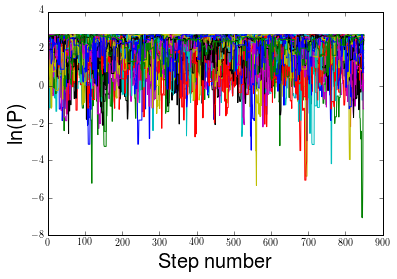

In [135]:
plt.figure(3)
[plt.plot(sampler.lnprobability[i,150:]) for i in range(100)]
plt.xlabel(r'Step number', fontsize = 20)
plt.ylabel(r'ln(P)', fontsize = 20)
plt.show()

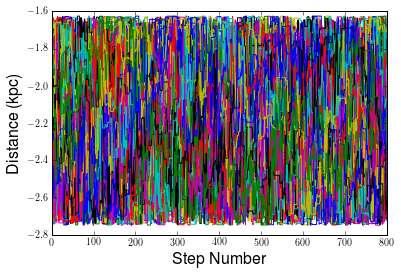

In [136]:
plt.figure(4)
[plt.plot(sampler.chain[i,200:,0]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'Distance (kpc)', fontsize = text_size)
plt.show()

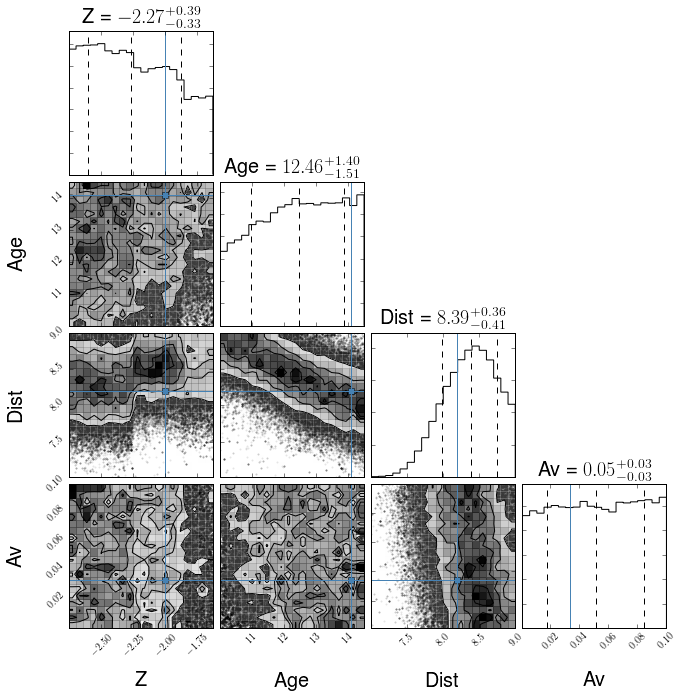

In [147]:
corner_plot1 = corner.corner(sampler.flatchain[100:,:], labels = ['Z','Age', 'Dist', 'Av'], show_titles = True,\
              plot_contours = True, truths = [-2.0,14.1 ,8.2, 0.034], quantiles = [0.16,0.5,0.84],
                           label_kwargs={"fontsize": 20}, title_kwargs={"fontsize": 20})
corner_plot1.show()

With the exception of age, every other parameter is within error bars of the true input value.

## Problem 2(c), $\sigma$ = 0.01
Repeat part (b), but assume photometric uncertainties of 0.01 mag. How, if at all, do the results differ from part (b)?

In [149]:
filt_01 = ['V','Cousins_I']
mags_01 = make_data(filt_01, sigma = 0.01)
n_walkers = 300
ndim = 4
n_steps = 1000
initial_01 = np.array([np.random.rand(ndim) for i in range(n_walkers)])
initial_01[:,0] = initial_01[:,0]*(z_max-z_min)+ z_min
initial_01[:,1] = initial_01[:,1]*(age_max - age_min) + age_min
initial_01[:,2] = initial_01[:,2]*(dist_max - dist_min) + dist_min
initial_01[:,3] = initial_01[:,3]*(av_max - av_min) + av_min
#print initial
sampler_01 = emcee.EnsembleSampler(n_walkers, ndim, lnprob, args=[mags_01, 0.01, filt_01])
sampler_01.run_mcmc(initial_01, n_steps)

(array([[ -2.51346216e+00,   1.16688397e+01,   8.76984151e+00,
           9.08312515e-03],
        [ -2.47861689e+00,   1.42317409e+01,   8.22583007e+00,
           1.54461538e-02],
        [ -2.56269699e+00,   1.09456160e+01,   8.66450103e+00,
           8.72066695e-02],
        ..., 
        [ -2.29815568e+00,   1.34203409e+01,   8.25534363e+00,
           3.71736820e-02],
        [ -2.72879995e+00,   1.23283917e+01,   8.32590708e+00,
           7.34847985e-02],
        [ -2.44070039e+00,   1.17571913e+01,   8.71776616e+00,
           1.43714681e-02]]),
 array([ 5.92657703,  7.15445469,  5.44877854,  6.68948011,  7.27377513,
         2.95990683,  7.24557303,  7.2658158 ,  6.10280606,  2.75521315,
         6.15527433,  6.70901625,  7.22519229,  6.73721901,  6.66100534,
         5.7010226 ,  4.07492056,  7.28545699,  7.22912844,  6.66714186,
         6.51591634,  6.81466008,  2.96087052,  6.84200543,  7.0386392 ,
         0.35713498,  5.96583184,  6.92169958,  6.93140913,  6.96547851,


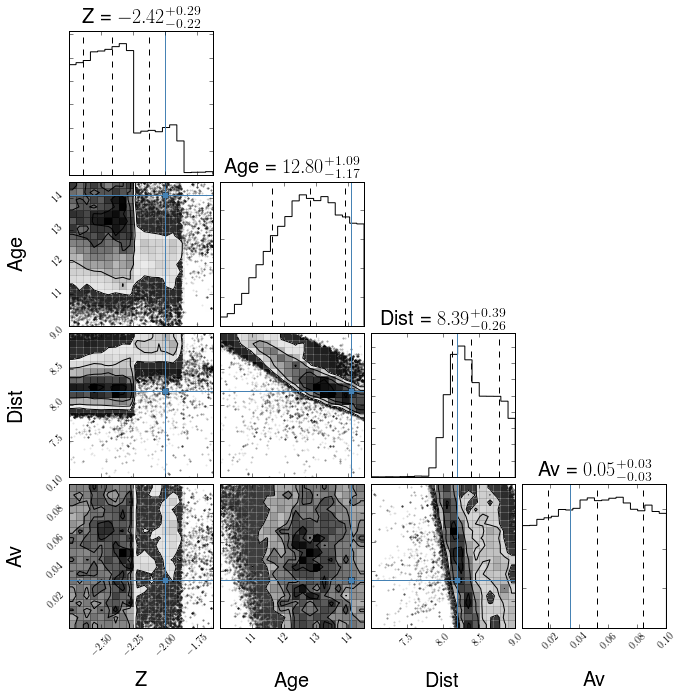

In [150]:
corner_plot2 = corner.corner(sampler_01.flatchain[100:,:], labels = ['Z','Age', 'Dist', 'Av'], show_titles = True,\
              plot_contours = True, truths = [-2.0,14.1 ,8.2, 0.034], quantiles = [0.16,0.5,0.84],
                           label_kwargs={"fontsize": 20}, title_kwargs={"fontsize": 20})
corner_plot2.show()

Running the code with a $\sigma$ = 0.01 mag increased the accuracy of the age and distance parameters. The resulting value of the extinction value remained the same. The estimate of the metallicity got worse. However, it is hard to fit for this value since it is quantized to only 3 tunable values (-2.5, -2.0 and -1.75).

## Problem 2(d), UBVI bands
Repeat part (b), but assume you now have access to (mock) photometry in the following 4 bands: UBVI. How, if at all, do the results differ from part(b)?

In [151]:
filt_ubvi = ['U','B','V','Cousins_I']
mags_ubvi = make_data(filt_ubvi, sigma = 0.1)
n_walkers = 300
ndim = 4
n_steps = 1000
initial_ubvi = np.array([np.random.rand(ndim) for i in range(n_walkers)])
initial_ubvi[:,0] = initial_ubvi[:,0]*(z_max-z_min)+ z_min
initial_ubvi[:,1] = initial_ubvi[:,1]*(age_max - age_min) + age_min
initial_ubvi[:,2] = initial_ubvi[:,2]*(dist_max - dist_min) + dist_min
initial_ubvi[:,3] = initial_ubvi[:,3]*(av_max - av_min) + av_min
sampler_ubvi = emcee.EnsembleSampler(n_walkers, ndim, lnprob, args=[mags_ubvi, 0.1, filt_ubvi])
sampler_ubvi.run_mcmc(initial_ubvi, n_steps)

(array([[ -2.30037284,  10.74377178,   8.63744375,   0.03374014],
        [ -2.45337134,  12.40015505,   8.52104244,   0.02012899],
        [ -2.58663421,  13.09980315,   8.14878737,   0.04028026],
        ..., 
        [ -2.55823899,  10.29602917,   8.99878633,   0.09435795],
        [ -1.75451164,  10.38630438,   8.97014054,   0.06858972],
        [ -2.36768088,  11.03109832,   8.84046422,   0.08845581]]),
 array([ 3.77967444,  3.84124632,  4.00020565,  4.3225714 ,  3.79300071,
         2.86998619,  3.9056881 ,  4.11777676,  3.90394031,  3.84745627,
         3.99814717,  4.12093069,  3.37478818,  4.13245829,  4.25181147,
         3.61273884,  4.03432019,  3.7861138 ,  3.4222954 , -0.48589844,
         3.95783654,  3.80454681,  1.28034871,  2.06841779,  3.01931012,
         4.25598979,  1.39801504,  2.54644254,  4.13730359,  3.64410509,
         3.38235646,  4.15009751,  1.44407948,  2.29999887,  3.92987659,
         0.74115849,  3.01626594,  3.8895347 ,  3.10211083,  2.57694374,
    

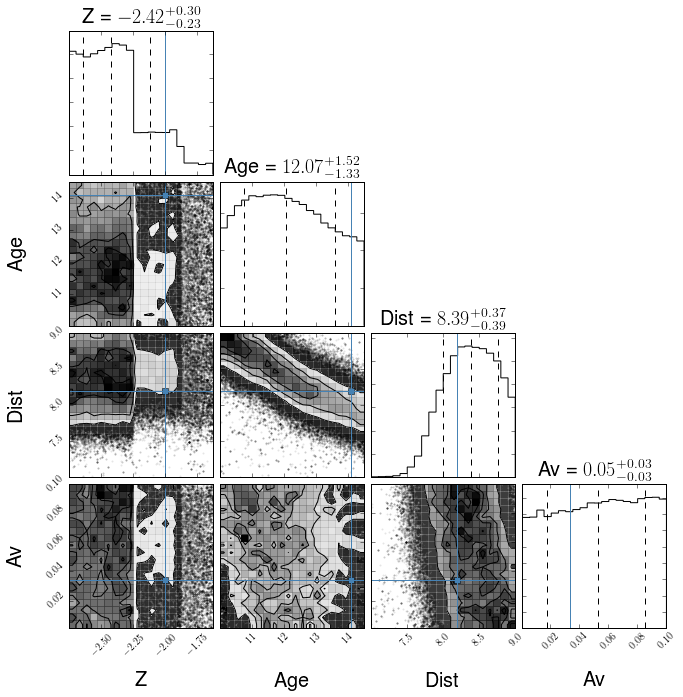

In [152]:
corner_plot3 = corner.corner(sampler_ubvi.flatchain[100:,:], labels = ['Z','Age', 'Dist', 'Av'], show_titles = True,\
              plot_contours = True, truths = [-2.0,14.1 ,8.2, 0.034], quantiles = [0.16,0.5,0.84],
                           label_kwargs={"fontsize": 20}, title_kwargs={"fontsize": 20})
corner_plot3.show()

Compared to (b), there is an increse in accuracy on the distance value, the age value is slightly farther from the true value. The extinction value seems unchanged by any sigma value or number of filters.

## Problem 2(e) UBVI+FUV
Repeat part (d) only now with the addition of the GALEX FUV filter. How, if at all, do the results differ from parts (b) and (d)? Does the far UV filter improve any constraints? What might be some challenges to using integrated UV observations of globular clusters?

In [142]:
filt_ubvig = ['U','B','V','Cousins_I','GALEX_FUV']
mags_ubvig = make_data(filt_ubvig, sigma = 0.1)
n_walkers = 300
ndim = 4
n_steps = 1000
initial_ubvig = np.array([np.random.rand(ndim) for i in range(n_walkers)])
initial_ubvig[:,0] = initial_ubvig[:,0]*(z_max-z_min)+ z_min
initial_ubvig[:,1] = initial_ubvig[:,1]*(age_max - age_min) + age_min
initial_ubvig[:,2] = initial_ubvig[:,2]*(dist_max - dist_min) + dist_min
initial_ubvig[:,3] = initial_ubvig[:,3]*(av_max - av_min) + av_min
sampler_ubvig = emcee.EnsembleSampler(n_walkers, ndim, lnprob, args=[mags_ubvig, 0.1, filt_ubvig])
sampler_ubvig.run_mcmc(initial_ubvig, n_steps)

(array([[ -2.53629829e+00,   1.37301743e+01,   7.52707961e+00,
           2.73872131e-02],
        [ -2.49288972e+00,   1.36419803e+01,   7.60871907e+00,
           9.80568210e-02],
        [ -2.34970816e+00,   1.31071132e+01,   7.62792119e+00,
           4.14087151e-02],
        [ -2.54636875e+00,   1.34946006e+01,   7.73639003e+00,
           3.93007749e-02],
        [ -2.56052250e+00,   1.27070284e+01,   8.02643313e+00,
           1.67125581e-02],
        [ -2.72301231e+00,   1.34616131e+01,   7.96407739e+00,
           1.81367122e-03],
        [ -2.36787133e+00,   1.42497949e+01,   7.69123752e+00,
           5.38534783e-02],
        [ -2.59525072e+00,   1.36646316e+01,   8.12956182e+00,
           6.18363414e-03],
        [ -2.71738901e+00,   1.37997490e+01,   8.01409245e+00,
           2.74060176e-02],
        [ -2.40885704e+00,   1.39899959e+01,   7.79746950e+00,
           5.89403161e-02],
        [ -2.51496106e+00,   1.33681028e+01,   7.89370067e+00,
           5.89276792e-02],

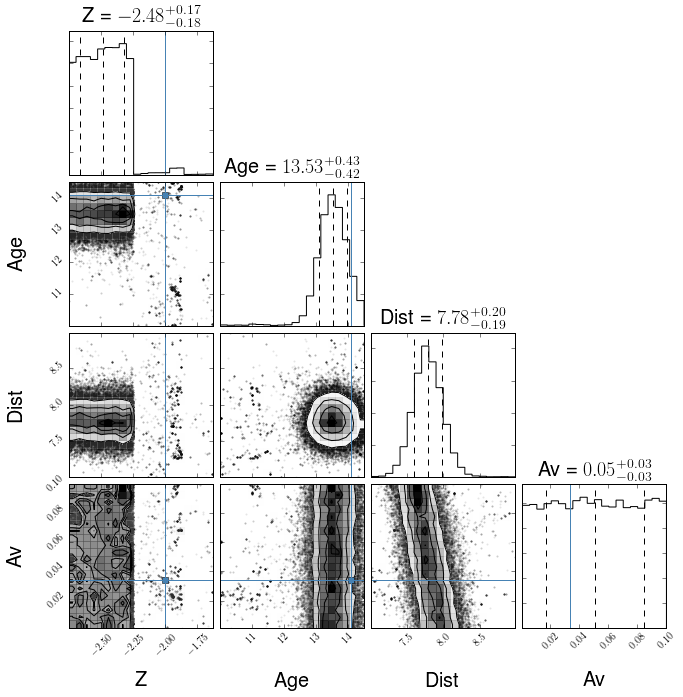

In [143]:
corner_plot = corner.corner(sampler_ubvig.flatchain[100:,:], labels = ['Z','Age', 'Dist', 'Av'], show_titles = True,\
              plot_contours = True, truths = [-2.0,14.1 ,8.2e3, 0.034], quantiles = [0.16,0.5,0.84],
                           label_kwargs={"fontsize": 20}, title_kwargs={"fontsize": 20})
corner_plot.show()

In this section, the distance and age seemed to be well determined- while the metallcity is still fairly uncertain. However, this is due to the fact that there are only 3 quantized values that can be selected, making it hard to fit to the right value. Compared to part b, the error bars have gotten smaller on metallicity, age and distance, staying about the same for extinction. Compared to part d, the distance became less accurate when the UV filter was added. However, the shape of the distribution is much more peaked, it is still centered at the wrong value. I imagine that in very old globular clusters the UV light will be much less significant than in younger clusters/stellar populations due to the fact that UV light is primarily given off by shorter-lived higher mass stars.

Overall, the size of difference between multiple runs of the same trial is similar to the differences between runs of different trials. 